<a href="https://colab.research.google.com/github/fayrouz2/ai-pros-v1-2025/blob/main/horse_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Build a Dataset Class for Horse Breeds**

https://www.kaggle.com/datasets/olgabelitskaya/horse-breeds

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torch.utils.data import Dataset, Subset, random_split, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from torchvision import datasets, models, transforms
from torch.utils.data import Subset
from collections import Counter


In [33]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("olgabelitskaya/horse-breeds")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'horse-breeds' dataset.
Path to dataset files: /kaggle/input/horse-breeds


### Dataset Class

In [34]:
class HorseDataset(Dataset):
     def __init__(self, root_dir, transform=None):
          self.root_dir = root_dir
          self.transform = transform
          self.images = sorted(os.listdir(root_dir))
          self.labels=[int(fname[:2]) - 1 for fname in self.images]
          self.label_map = self.load_labels()
          
     def __len__(self):
        return len(self.images)
     
     def __getitem__(self, idx):
        filename = self.images[idx]
        img_path = os.path.join(self.root_dir, filename)

        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label
   

     def load_labels(self):
         label_map = {
            1: "Akhal-Teke",
            2: "Appaloosa",
            3: "Orlov Trotter",
            4: "Vladimir Heavy Draft",
            5: "Percheron",
            6: "Arabian",
            7: "Friesian",
        }
         return label_map


In [35]:
dataset=HorseDataset(path)

In [38]:
class_counts = Counter(dataset.labels)
print(class_counts)

Counter({0: 123, 5: 122, 6: 120, 2: 107, 1: 105, 4: 56, 3: 37})


In [8]:
img, label = dataset[50]

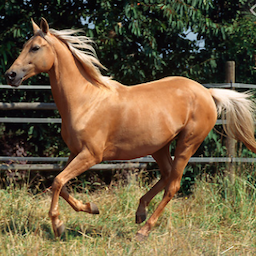

In [9]:
img

In [10]:
img.size

(256, 256)

In [11]:
label

0

In [12]:
dataset.label_map[label+1]

'Akhal-Teke'

In [13]:
print(f'Number of samples in the dataset: {len(dataset)}\n')

Number of samples in the dataset: 670



### Transforms

In [14]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
    #normalize
])

In [15]:
dataset=HorseDataset(path, transform=transform)

In [16]:
#loader to calculate mean and std
loader = DataLoader(dataset, batch_size=32, shuffle=False)

mean = 0.
std = 0.
nb_samples = 0

for images, _ in loader:  # images.shape = (B, 3, H, W)
    batch_samples = images.size(0)
    images = images.view(batch_samples, 3, -1)  # flatten H*W
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)
    nb_samples += batch_samples

mean /= nb_samples
std /= nb_samples


In [17]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

In [18]:
dataset=HorseDataset(path, transform=transform)

### Split the data into train val, and test set (starified)

In [19]:
def stratified_split_dataset(dataset, val_fraction=0.15, test_fraction=0.15, seed=42):

    labels = np.array(dataset.labels)
    indices = np.arange(len(dataset))

    sss1 = StratifiedShuffleSplit(
        n_splits=1,
        test_size=test_fraction,
        random_state=seed
    )

    train_val_idx, test_idx = next(sss1.split(indices, labels))

    val_ratio_adjusted = val_fraction / (1 - test_fraction)

    sss2 = StratifiedShuffleSplit(
        n_splits=1,
        test_size=val_ratio_adjusted,
        random_state=seed
    )

    train_idx, val_idx = next(
        sss2.split(train_val_idx, labels[train_val_idx])
    )

    train_idx = train_val_idx[train_idx]
    val_idx = train_val_idx[val_idx]

    return (
        Subset(dataset, train_idx),
        Subset(dataset, val_idx),
        Subset(dataset, test_idx)
    )


In [20]:
# def split_dataset(dataset, val_fraction=0.15, test_fraction=0.15):

#     total_size = len(dataset)
#     val_size = int(total_size * val_fraction)
#     test_size = int(total_size * test_fraction)
#     train_size = total_size - val_size - test_size

#     train_dataset, val_dataset, test_dataset = random_split(
#         dataset, [train_size, val_size, test_size]
#     )
#     return train_dataset, val_dataset, test_dataset

In [21]:
train_dataset, val_dataset, test_dataset = stratified_split_dataset(dataset)

In [22]:
print(f"Length of training dataset:   {len(train_dataset)}")
print(f"Length of validation dataset: {len(val_dataset)}")
print(f"Length of test dataset:       {len(test_dataset)}")

Length of training dataset:   468
Length of validation dataset: 101
Length of test dataset:       101


### Create Dataloader objects

In [23]:
batch_size = 32

train_dataloader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

test_dataloader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

#### Display some images

In [24]:
img_t, label_t = dataset[50]


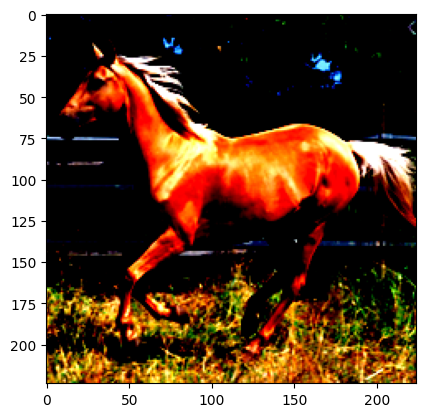

In [25]:
plt.imshow(img_t.permute(1, 2, 0))
plt.show()


### Define Model

In [27]:
model_ft = models.resnet18(weights='DEFAULT')


### define Loss and Optimizer

#### Build one_epoch_training function loop

#### Build one_epoch_validation function loop

### Combine all to train the model
it should Save the best model and track train and val loss and accuracy


### test the model on test set

### show some predictions with the images

### Analyze the results
Is the model overfitting/underfitting?
Plot the training and validation loss/accuracy curves

### Load the model